In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import lightning.pytorch as pl
from torchvision import transforms, datasets, models

c:\Users\benja\Documents\Code\learning\pytorch-lightning\.venv\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
transform = transforms.ToTensor()
train_set = datasets.CIFAR10(root='CIFAR10', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='CIFAR10', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt

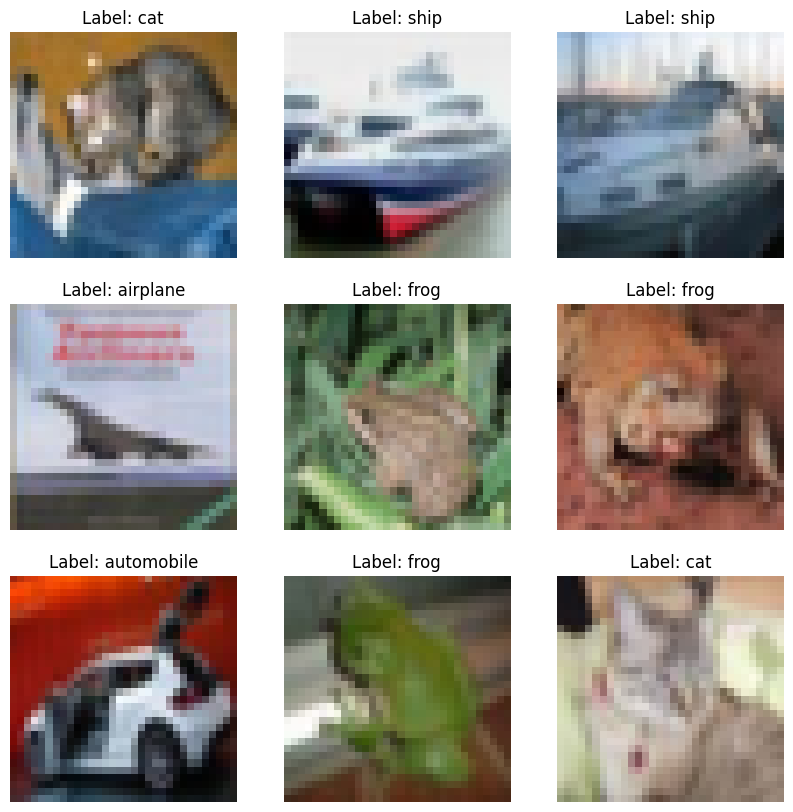

In [4]:
# view a couple from the test set on a 3x3 grid with labels

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    img, label = test_set[i]
    ax.imshow(img.permute(1, 2, 0))
    label = test_set.classes[label]
    ax.set_title(f"Label: {label}")
    ax.axis("off")

In [5]:
class CIFAR10Classifier(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        backbone = models.resnet50(weights="DEFAULT")  

        # freeze all layers 
        for name, param in backbone.named_parameters():
            if name.startswith("layer4") or name.startswith("fc"):
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        self.learning_rate = learning_rate
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)



        self.classifier = nn.Linear(num_filters, 10)

    def forward(self, x):
        representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(-1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(-1) == y).float().mean()
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(-1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

In [6]:
class CIFAR10DataLoader(pl.LightningDataModule):
    def __init__(self, train_ds, test_ds, batch_size=32):
        super().__init__()
        self.train_ds = train_ds
        self.test_ds, self.val_ds = random_split(test_ds, [int(0.8*len(test_ds)), int(0.2*len(test_ds))])
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size)

In [7]:
loader = CIFAR10DataLoader(
    train_set,
    test_set
)

train_loader = loader.train_dataloader()
test_loader = loader.test_dataloader()
val_loader = loader.val_dataloader()

In [8]:
model = CIFAR10Classifier()

In [9]:
for item in train_loader:
    x, y = item
    print(x.shape, y.shape)
    check = model(x)
    print(check.shape)
    break

torch.Size([32, 3, 32, 32]) torch.Size([32])
torch.Size([32, 10])


In [10]:
from lightning.pytorch.utilities.model_summary import ModelSummary

summary = ModelSummary(model, max_depth=-1)
summary

    | Name                               | Type              | Params
---------------------------------------------------------------------------
0   | feature_extractor                  | Sequential        | 23.5 M
1   | feature_extractor.0                | Conv2d            | 9.4 K 
2   | feature_extractor.1                | BatchNorm2d       | 128   
3   | feature_extractor.2                | ReLU              | 0     
4   | feature_extractor.3                | MaxPool2d         | 0     
5   | feature_extractor.4                | Sequential        | 215 K 
6   | feature_extractor.4.0              | Bottleneck        | 75.0 K
7   | feature_extractor.4.0.conv1        | Conv2d            | 4.1 K 
8   | feature_extractor.4.0.bn1          | BatchNorm2d       | 128   
9   | feature_extractor.4.0.conv2        | Conv2d            | 36.9 K
10  | feature_extractor.4.0.bn2          | BatchNorm2d       | 128   
11  | feature_extractor.4.0.conv3        | Conv2d            | 16.4 K
12  | feature_

In [11]:
from lightning.pytorch.tuner.tuning import Tuner
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.loggers.wandb import WandbLogger
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "./level_3_use_pretrained_models.ipynb"

# early stopping is also handled effortlessly with callbacks


trainer = pl.Trainer()
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, train_loader, val_loader, max_lr=1e-2, min_lr=1e-5, num_training=1000)

logger = WandbLogger(name="cifar_thing_2", project="CIFAR10", log_model="all")

early_stop_callback = EarlyStopping(
    monitor="val_acc",
    min_delta=0.00,
    patience=7,
    verbose=True,
    mode="max"
)
trainer = pl.Trainer(max_epochs=50, callbacks=[early_stop_callback], logger=logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\benja\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\lightning\pytorch\loops\utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3050') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\benja\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not

Finding best initial lr:   0%|          | 0/1000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
Learning rate set to 0.008709635899560805
Restoring states from the checkpoint path at c:\Users\benja\Documents\Code\learning\pytorch-lightning\lightning-15-mins\basic_skills\.lr_find_5a709b81-b0e8-46f5-93d2-87ef0a5dab0b.ckpt
Restored all states from the checkpoint at c:\Users\benja\Documents\Code\learning\pytorch-lightning\lightning-15-mins\basic_skills\.lr_find_5a709b81-b0e8-46f5-93d2-87ef0a5dab0b.ckpt
wandb: Currently logged in as: benjaminvh1997. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


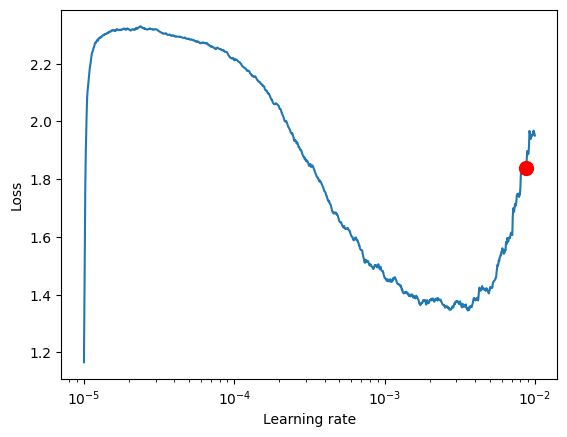

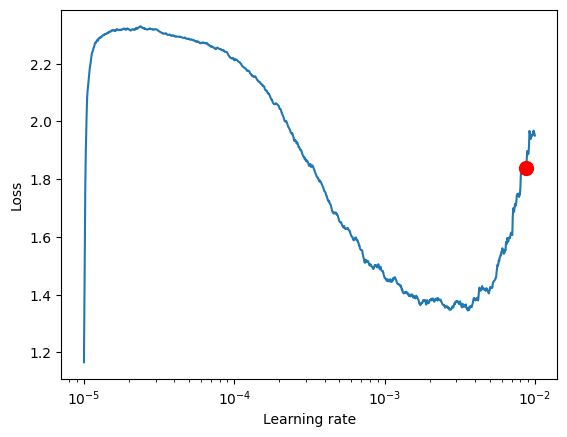

In [12]:
lr_finder.plot(suggest=True)

In [42]:
lr_finder.suggestion()

0.007691304402866094

In [13]:
model.learning_rate = 3e-4

In [14]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 23.5 M
1 | classifier        | Linear     | 20.5 K
-------------------------------------------------
15.0 M    Trainable params
8.5 M     Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\benja\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benja\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_acc improved. New best score: 0.703


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.028 >= min_delta = 0.0. New best score: 0.732


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.016 >= min_delta = 0.0. New best score: 0.748


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.748


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.013 >= min_delta = 0.0. New best score: 0.761


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.762
c:\Users\benja\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\lightning\pytorch\trainer\call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
